# Module 02 Project#

## Introduction##

This project provides a .csv database for a ficticious company named "Northwind Traders".

The database captures all the sales transactions that occurs between the company i.e. Northwind traders and its customers as well as the purchase transactions between Northwind and its suppliers.

From this database, we will look to generate analytical insights that could be of value to the company via the use of our statistical analysis and hypothesis testing.

I will conduct my experiment based on the general structure of experimental design:

1. **Make an observation**

2. **Examine the research**

3. **Form a Hypothesis** 

4. **Conduct an experiment and/or gather your of Data** 

5. **Analyze the Results**

6. **Draw Conclusions** 



### 1. Make an observation###

The database has tables reflecting orders sold, customers placing orders, employees, regions where customers and also the employes are located, etc. A complete schema of the Northwind database is here

The following ERD Diagram describes the Northwind Traders Database:

<img src='Northwind_ERD.png'>


Must companies are interested in their performance: levels of sale, quantities, times, profitability and  there are a number of questions I consider would be helpful to learn about Northwind.

### 2. Examine research### 

Looking at our database schema I have areas of interest that would like to explore further. These are posed as questions below and will be answered in this project.

**Question 1:** Do discounts have a statistically significant effect in the number of product customers order? If so, at what level(s) of discount?

**Question 2:** If I choose a random sample of Undiscounted products sold and Discounted products sold, what is the probability that the Undiscounted are smaller than the Discounted

**Question 3:** Does a particular product (or category) sell better in different Regions?

**Question 4:** Is the profit of a particular product (or category) affected by the Region?

**Question 5:** Does the sale of a product (ex: most profitable) change by Season? 

**Question 6:** Does the total cost of an order affect the cost of freight used? per shipper?

### Question 1: Do discounts have a statistically significant effect in the number of product customers order? If so, at what level(s) of discount?


### 3. Form a hypothesis

#### Null hypothesis statement

First thing I try to identify is the change in the quantity of products sold based on discount. The null-hypothesis addresses the fact that there is no change and sales of products with or without discount is exactly the same. 

>$H_{0}$: *The discount of a product does not have a significant effect on the number of products ordered* 



#### Alternate hypothesis
    
Our alternate hypothesis is that there is a change in the quantity of products sold based on discount.

>$H_{A}$: *The discount of a product does have a significant effect on the number of products ordered*



### 4. Conduct an experiment

First we gather our data by loading the necessary libaries, opening database and start query of data


In [182]:
# Importing the required libraries
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import kurtosis, skew

# Ignoring the FutureWarnings to allow smooth run of code (graphs)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Creating an engine and connecting to a database with SQLAlchemy
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

2019-06-13 12:30:58,426 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-13 12:30:58,427 INFO sqlalchemy.engine.base.Engine ()
2019-06-13 12:30:58,453 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-13 12:30:58,454 INFO sqlalchemy.engine.base.Engine ()


In [183]:
# Inspect tables to confirm table names match
from sqlalchemy import inspect

inspector = inspect(engine)
print(inspector.get_table_names())

2019-06-13 12:31:01,338 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-13 12:31:01,339 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [184]:
# define a function to inspect tables and confirm column names for the tables I plan on using
def get_columns_info(table_name):
    columns_list = inspector.get_columns(table_name)
    print ("Table Name: {}".format(table_name))
    for column in columns_list:
        print("Column: {}\t\tType:{}".format(column['name'],column['type']))
    print("")

In [185]:
# print the columns for my tables of interest
#get_columns_info('Customer')
#get_columns_info('CustomerDemographic') # this is empty
#get_columns_info('Order')
get_columns_info('OrderDetail')
#get_columns_info('Product')
#get_columns_info('Category')

2019-06-13 12:31:06,128 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-06-13 12:31:06,129 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail
Column: Id		Type:VARCHAR(8000)
Column: OrderId		Type:INTEGER
Column: ProductId		Type:INTEGER
Column: UnitPrice		Type:DECIMAL
Column: Quantity		Type:INTEGER
Column: Discount		Type:FLOAT



In [186]:
#run some basic query to get to know the type of data

# Per product, how many sales and where (which customers)
q_var = ''' SELECT p.ProductName, cat.CategoryName, p.UnitPrice, od.UnitPrice, od.Discount, od.Quantity, o.Id
FROM Product p 
JOIN Category cat ON p.CategoryId = cat.Id
JOIN OrderDetail od ON p.ID = od.ProductId
JOIN [Order] o ON od.OrderId = o.Id'''

df_tmp = pd.read_sql_query(q_var, engine)
print(len(df_tmp))
df_tmp.head(10)

2019-06-13 12:31:08,941 INFO sqlalchemy.engine.base.Engine  SELECT p.ProductName, cat.CategoryName, p.UnitPrice, od.UnitPrice, od.Discount, od.Quantity, o.Id
FROM Product p 
JOIN Category cat ON p.CategoryId = cat.Id
JOIN OrderDetail od ON p.ID = od.ProductId
JOIN [Order] o ON od.OrderId = o.Id
2019-06-13 12:31:08,944 INFO sqlalchemy.engine.base.Engine ()
2155


,ProductName,CategoryName,UnitPrice,UnitPrice,Discount,Quantity,Id
0,Queso Cabrales,Dairy Products,21.00,14.0,0.00,12,10248
1,Singaporean Hokkien Fried Mee,Grains/Cereals,14.00,9.8,0.00,10,10248
2,Mozzarella di Giovanni,Dairy Products,34.80,34.8,0.00,5,10248
3,Tofu,Produce,23.25,18.6,0.00,9,10249
4,Manjimup Dried Apples,Produce,53.00,42.4,0.00,40,10249
5,Jack's New England Clam Chowder,Seafood,9.65,7.7,0.00,10,10250
6,Manjimup Dried Apples,Produce,53.00,42.4,0.15,35,10250
7,Louisiana Fiery Hot Pepper Sauce,Condiments,21.05,16.8,0.15,15,10250
8,Gustaf's Knäckebröd,Grains/Cereals,21.00,16.8,0.05,6,10251
9,Ravioli Angelo,Grains/Cereals,19.50,15.6,0.05,15,10251


In [8]:
# Extract all the orders with their products and quantities
q_var = ''' SELECT od.ProductId, od.UnitPrice, od.Discount, od.Quantity, od.UnitPrice*od.Quantity AS CostProduct,
od.UnitPrice*od.Quantity*(1-od.Discount) AS DiscountedCostProduct, o.Id
FROM [Order] o 
JOIN OrderDetail od ON od.OrderId = o.Id
ORDER BY od.ProductId ASC
'''

df_t1 = pd.read_sql_query(q_var, engine)
print(len(df_t1))
df_t1.head()

2019-06-13 10:04:10,807 INFO sqlalchemy.engine.base.Engine  SELECT od.ProductId, od.UnitPrice, od.Discount, od.Quantity, od.UnitPrice*od.Quantity AS CostProduct,
od.UnitPrice*od.Quantity*(1-od.Discount) AS DiscountedCostProduct, o.Id
FROM [Order] o 
JOIN OrderDetail od ON od.OrderId = o.Id
ORDER BY od.ProductId ASC

2019-06-13 10:04:10,808 INFO sqlalchemy.engine.base.Engine ()
2155


,ProductId,UnitPrice,Discount,Quantity,CostProduct,DiscountedCostProduct,Id
0,1,14.4,0.20,45,648.0,518.4,10285
1,1,14.4,0.00,18,259.2,259.2,10294
2,1,14.4,0.00,20,288.0,288.0,10317
3,1,14.4,0.15,15,216.0,183.6,10348
4,1,14.4,0.00,12,172.8,172.8,10354


Now that we have some additional knowledge about the type of products, I would like to have the Quantity of products sold without Discount and store in a dataframe

In [187]:
# Extract all the orders with their products and quantities WHERE od.Discount = 0
q_var = ''' SELECT od.ProductId, od.UnitPrice, od.Discount, od.Quantity, od.UnitPrice*od.Quantity AS CostProduct,
od.UnitPrice*od.Quantity*(1-od.Discount) AS DiscountedCostProduct, o.Id
FROM [Order] o 
JOIN OrderDetail od ON od.OrderId = o.Id
WHERE od.Discount = 0
ORDER BY od.ProductId ASC
'''

df_D0 = pd.read_sql_query(q_var, engine)
print(len(df_D0))
print(df_D0['Quantity'].mean())
df_D0.head(10)

2019-06-13 12:31:12,753 INFO sqlalchemy.engine.base.Engine  SELECT od.ProductId, od.UnitPrice, od.Discount, od.Quantity, od.UnitPrice*od.Quantity AS CostProduct,
od.UnitPrice*od.Quantity*(1-od.Discount) AS DiscountedCostProduct, o.Id
FROM [Order] o 
JOIN OrderDetail od ON od.OrderId = o.Id
WHERE od.Discount = 0
ORDER BY od.ProductId ASC

2019-06-13 12:31:12,754 INFO sqlalchemy.engine.base.Engine ()
1317
21.715261958997722


,ProductId,UnitPrice,Discount,Quantity,CostProduct,DiscountedCostProduct,Id
0,1,14.4,0.0,18,259.2,259.2,10294
1,1,14.4,0.0,20,288.0,288.0,10317
2,1,14.4,0.0,12,172.8,172.8,10354
3,1,14.4,0.0,10,144.0,144.0,10406
4,1,14.4,0.0,24,345.6,345.6,10413
5,1,14.4,0.0,15,216.0,216.0,10477
6,1,18.0,0.0,10,180.0,180.0,10576
7,1,18.0,0.0,20,360.0,360.0,10590
8,1,18.0,0.0,3,54.0,54.0,10609
9,1,18.0,0.0,6,108.0,108.0,10611


We also would like to have the Quantity of products sold with Discount

In [188]:
# Extract all the orders with their products and quantities WHERE od.Discount <> 0
q_var = ''' SELECT od.ProductId, od.UnitPrice, od.Discount, od.Quantity, od.UnitPrice*od.Quantity AS CostProduct,
od.UnitPrice*od.Quantity*(1-od.Discount) AS DiscountedCostProduct, o.Id
FROM [Order] o 
JOIN OrderDetail od ON od.OrderId = o.Id
WHERE od.Discount <> 0
ORDER BY od.ProductId ASC
'''

df_Disc = pd.read_sql_query(q_var, engine)
print(len(df_Disc))
print(df_Disc['Quantity'].mean())
df_Disc.head(10)

2019-06-13 12:31:15,297 INFO sqlalchemy.engine.base.Engine  SELECT od.ProductId, od.UnitPrice, od.Discount, od.Quantity, od.UnitPrice*od.Quantity AS CostProduct,
od.UnitPrice*od.Quantity*(1-od.Discount) AS DiscountedCostProduct, o.Id
FROM [Order] o 
JOIN OrderDetail od ON od.OrderId = o.Id
WHERE od.Discount <> 0
ORDER BY od.ProductId ASC

2019-06-13 12:31:15,302 INFO sqlalchemy.engine.base.Engine ()
838
27.10978520286396


,ProductId,UnitPrice,Discount,Quantity,CostProduct,DiscountedCostProduct,Id
0,1,14.4,0.20,45,648.0,518.4,10285
1,1,14.4,0.15,15,216.0,183.6,10348
2,1,14.4,0.15,15,216.0,183.6,10370
3,1,18.0,0.20,40,720.0,576.0,10522
4,1,18.0,0.15,8,144.0,122.4,10526
5,1,18.0,0.25,15,270.0,202.5,10646
6,1,18.0,0.25,35,630.0,472.5,10689
7,1,18.0,0.20,5,90.0,72.0,10700
8,1,18.0,0.25,4,72.0,54.0,10838
9,1,18.0,0.20,80,1440.0,1152.0,10847


One of the **conditions for our hypothesis testing** is that we are working with data that has a **normal distribution**. 

Normality is important because I would like to apply  a parametric test which increase the chances of finding variability in our data hence finding significant results.

To determine Normality we follow a multi step approach - to test our hypothesis: 

#### Step 1) We state our **Normality hypothesis** as follows:

### Null hypothesis##

>$H_{0}$: the data is normally distributed 
    
### Alternative hypothesis##

>$H_{A}$: the data it is Not normally distributed


#### Step 2) We provide a graphical representation for our data

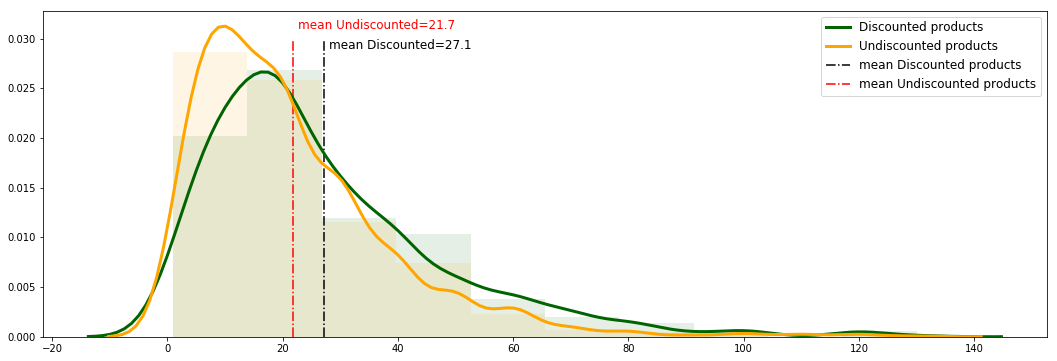

In [189]:
#define the graph size
plt.subplots(figsize = (18,6))

#Plot the Discounted
plt.hist(df_Disc.Quantity, density=True, alpha = 0.1, color = 'darkgreen')
sns.kdeplot(df_Disc.Quantity, shade = False, color = 'darkgreen', label='Discounted products', linewidth=3)
plt.vlines(df_Disc.Quantity.mean(), 0, .03, color = 'black', linestyles='-.', label='mean Discounted products')
plt.text(df_Disc.Quantity.mean()+1, .029, r"mean Discounted="+ str(round(df_Disc.Quantity.mean(),1)), 
         {'color': 'black', 'fontsize': 12},horizontalalignment='left')

#Plot the Undiscounted
plt.hist(df_D0.Quantity, density=True, alpha = 0.1, color = 'Orange')
sns.kdeplot(df_D0.Quantity, shade = False, color = 'orange', label='Undiscounted products',  linewidth=3)
plt.vlines(df_D0.Quantity.mean(), 0, .03, color = 'red', linestyles='-.', label='mean Undiscounted products')
plt.text(df_D0.Quantity.mean()+1, .031, r"mean Undiscounted="+ str(round(df_D0.Quantity.mean(),1)), 
         {'color': 'red', 'fontsize': 12},horizontalalignment='left')

plt.legend(loc='upper right',fontsize = 12)
plt.show()

We note what seems to be positive kurtosis - with the tail extending to the right for both distributions. 

#### Step 3) Measure the symmetry of our data

Having the quantification for the asymmetry would confirm our observation from the graphs.

In [12]:
#measure kurtosis and skewness
print('Skeweness Discounted = ', skew(df_Disc.Quantity) )
print('Kurtosis Discounted = ', kurtosis(df_Disc.Quantity) )
print('Skeweness Undiscounted = ', skew(df_D0.Quantity) )
print('Kurtosis Undiscounted = ', kurtosis(df_D0.Quantity) )

Skeweness Discounted =  1.5815727350866624
Kurtosis Discounted =  3.2855655338966683
Skeweness Undiscounted =  1.9115988573935332
Kurtosis Undiscounted =  5.771124915313802


There are some general gidelines about considering a normal distribution based on Skeweness (+/- 2) and Kurtosis (+/-3) however are only used as referece and are not conclusive.  Other methods provide a better answer to the question of how comfortable we are with our data being normal enough to hold the normality assumptions. Kolmogorov-Smirnov test (K-S) is one of them, designed to compare our data to a normal distribution  with the same mean and standard deviation as our sample.

If we obtain a significance level(p-value) below the cut-off value we have set (0.05 in this case), we reject the null hypothesis and accept the alternative hypothesis. Alternatively, if we obtain a significance level above the cut-off value, we fail to reject the null hypothesis and cannot accept the alternative hypothesis. 

In [190]:
#define a function that creates a sample with normal distribution and same mean and standard deviation as our sample
def sample_data(data, size):
    x_sample = stats.norm.rvs(loc=data.mean(),scale=data.std(), size = size)
    return x_sample

# define a function that tests measure of the strength of evidence against H0 -the NULL hypothesis of normality 
# for our data. H
def result_ks_test(data, size):
    confirmation = np.array([['Not', 'indicates normallity'],['','are not normal']])
    result = stats.kstest(sample_data(data, size), 'norm', args = (data.mean(), data.std()))
    if result[1] > 0.05:
        option = 0
    else:
        option = 1
    #print(f'{result}')
    print(f'K-S = {result[1]}, the test is {confirmation[option][0]} significant: data {confirmation[option][1]}')
    return

In [191]:
#running the K-S test for both our data for Discounted and Undiscounted products
result_ks_test(df_Disc.Quantity,1000)
result_ks_test(df_D0.Quantity,1000)

K-S = 0.5643314518585464, the test is Not significant: data indicates normallity
K-S = 0.03683564975496756, the test is  significant: data are not normal


#### Step 4) We interpret the results and Reject or Fail to Reject the NULL hypothesis

Any p-value above .05 indicates we have 5% (or less) of probability of rejecting the Null hypothesis when it's true; it is statistically significant to say that **there is normality in the distribution of both our Discounted and Undiscounted product data**.  

### 4. Analyze the Results

Now that we have met the condition of Normality for our data, we want to know the magnitude of the difference between our two groups - to confirm or reject our initial Null hypothesis: The discount of a product does not have a significant effect on the number of products ordered. For this, we select Cohen's d to measure the number of standard deviations between the means of our 2 samples Discounted and Undiscounted 

In [192]:
#define function to calculate Cohen's D value
def Cohen_d(data1, data2):
    ''' 
    data1 and data2 are Series or Numpy arrays, the function returns the d value
    '''
    n1,n2 = len(data1), len(data2)
    mean1,mean2 = data1.mean(), data2.mean()
    var1,var2 = data1.var(), data2.var()
    std1, std2 = data1.std(), data2.std()
    
    #calculate the pooled thershold
    pooled_var = (n1*var1 + n2*var2)/(n1+n2)
    
    #calculate Cohen's statistic
    d = (mean1-mean2)/np.sqrt(pooled_var)

    return d

In [193]:
#Compare now the Discount vs the Undiscounted quantities of products sold
print(f'Cohen\'s d = {Cohen_d(df_Disc.Quantity, df_D0.Quantity)}')

Cohen's d = 0.2862724481729286


We **Reject** the NULL hypothesis as, according to Cohen d's value guidelines, there's Small-Medium effect for the difference in Quantity of Product sold between Discounted and Undiscounted.

### 5. Draw conclusions

Our test indicates that there is significant effect in the number of product customers order if there is a Discount. Northwind Trade may be interested in keeping this practice as it presents a positive results on the amount of products in their orders. It may also be of interest to explore further on the type of products, regions, customers etc if a more granular detail is desired.

### Now we can answer Question 1(b) :  at what level(s) of discount do discounts have a statistically significant effect in the number of product customers orders?

### 1. Make an observation###

From our previous example we already noted that there are multiple discounts, but we would like to know how many values we have:

In [194]:
# Display number of values
df_Disc.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

### 2. Examine research

Forming different dataset with products based on a range of discount values, let's say by increments of 5%

In [195]:
# creating dataframes for the ranges of 0.1-0.5, 0.6-.1, 0.15, 0.20 and 0.25
initial = 0
increment = 0.05
beg_range = initial
end_range = increment
lst_nm = []
df_collection = {}
i=0
# define the number of dataframes to use
for nm in ['05','10','15','20','25']:
    
    #create the distinc name of the dataframe
    key_name = 'df_Disc'+str(nm)
    print(f'Dataframe name: {key_name}, Range discount > {round(beg_range,2)} <= {round(end_range,2)}')
    lst_nm.insert(i,key_name)
    
    # create a dataframe and select the data that corresponds to range of Discount
    df_collection[key_name] = pd.DataFrame()
    df_collection[key_name] = df_Disc.loc[(df_Disc.Discount>beg_range) & (df_Disc.Discount<=end_range)]
    print(f'Size Dataframe: {len(df_collection[key_name])}')
    
    beg_range = end_range
    end_range = end_range+increment
    i+= 1

print(lst_nm)

Dataframe name: df_Disc05, Range discount > 0 <= 0.05
Size Dataframe: 192
Dataframe name: df_Disc10, Range discount > 0.05 <= 0.1
Size Dataframe: 174
Dataframe name: df_Disc15, Range discount > 0.1 <= 0.15
Size Dataframe: 157
Dataframe name: df_Disc20, Range discount > 0.15 <= 0.2
Size Dataframe: 161
Dataframe name: df_Disc25, Range discount > 0.2 <= 0.25
Size Dataframe: 154
['df_Disc05', 'df_Disc10', 'df_Disc15', 'df_Disc20', 'df_Disc25']


We note that the size of each of the dataframes (number of items for each of the different ranges) is similar; however we are interested in the Quantity of Products sold per Discount range having an impact and we'll define our hypothesis based on that.

### 3. Form a hypothesis

#### Null hypothesis statement

First we identify is the change in the quantity of products sold based on discount. The null-hypothesis addresses the fact that there is no change and sales of products with or without discount is exactly the same. 

>$H_{0}$: *The discount of a product does not have a significant effect on the number of products ordered* 



#### Alternate hypothesis
    
Our alternate hypothesis is that there is a change in the quantity of products sold based on discount.

>$H_{A}$: *The discount of a product does have a significant effect on the number of products ordered*



### 4. Conduct an experiment

If we would like to test the Null hypothesis versus each dataset, having a very similar distribution and mean would be a good indicator that all datasets behave the same way with or without discount. So we start by the determination of Normality in each of our datasets

We follow a multi step approach - to test our hypothesis: 

#### Step 1) We state our **Normality hypothesis** as follows:

### Null hypothesis##

>$H_{0}$: the data is normally distributed 
    
### Alternative hypothesis##

>$H_{A}$: the data it is Not normally distributed


#### Step 2) We provide a graphical representation for our data

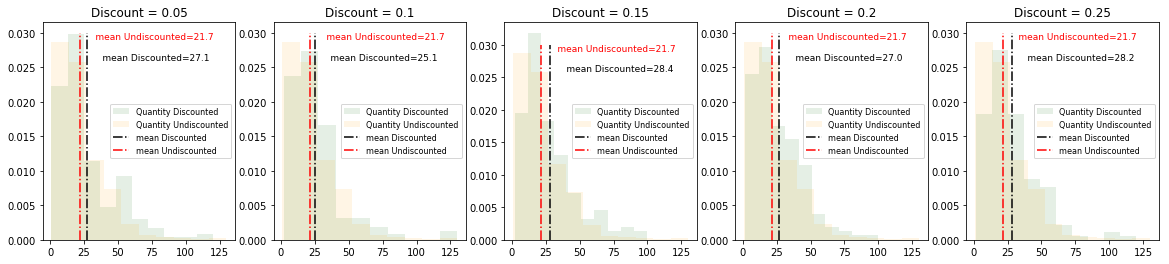

In [248]:
#display the subplots next to each other
fig,axes = plt.subplots(figsize=(20,4), ncols = 5)

for ax, z in zip(axes, range(len(lst_nm))):
    
    #Plot the Discounted datasets one by one
    #for z in range(len(lst_nm)):
    ax.hist(df_collection[lst_nm[z]].Quantity, density=True, alpha = 0.1, color = 'darkgreen',label='Quantity Discounted')
    ax.vlines(df_collection[lst_nm[z]].Quantity.mean(), 0, .03, color = 'black', linestyles='-.', label='mean Discounted')
    ax.text(df_collection[lst_nm[z]].Quantity.mean()+1, .026, 
            r"     mean Discounted="+ str(round(df_collection[lst_nm[z]].Quantity.mean(),1)), 
         {'color': 'black', 'fontsize': 9},horizontalalignment='left')
    ax.set_title(f'Discount = {df_collection[lst_nm[z]].Discount.max()}')
    
    #Plot the Undiscounted
    ax.hist(df_D0.Quantity, density=True, alpha = 0.1, color = 'Orange',label='Quantity Undiscounted')
    ax.vlines(df_D0.Quantity.mean(), 0, .03, color = 'red', linestyles='-.', label='mean Undiscounted')
    ax.text(df_D0.Quantity.mean()+1, .029, r"     mean Undiscounted="+ str(round(df_D0.Quantity.mean(),1)), 
         {'color': 'red', 'fontsize': 9},horizontalalignment='left')
    ax.legend(loc='center right',fontsize = 8)
plt.show()

#### Step 3) Measure the symmetry of our data
Having the quantification for the asymmetry would confirm our observation from the graphs.

In [203]:
#   measure kurtosis, kewness and running the K-S test for each dataframe

for discount in range(len(lst_nm)):
    print(f'\nDiscount {df_collection[lst_nm[discount]].Discount.max()}')
    print(f'Skeweness = ', skew(df_collection[lst_nm[discount]].Quantity) )
    print(f'Kurtosis = ', kurtosis(df_collection[lst_nm[discount]].Quantity) )
    result_ks_test(df_collection[lst_nm[z]].Quantity,1000)


Discount 0.05
Skeweness =  1.5874358685350642
Kurtosis =  2.7291043769009002
K-S = 0.917074308026893, the test is Not significant: data indicates normallity

Discount 0.1
Skeweness =  2.2070318192308593
Kurtosis =  6.727900595581794
K-S = 0.054566357093924545, the test is Not significant: data indicates normallity

Discount 0.15
Skeweness =  1.3079736552989059
Kurtosis =  1.4684627433848405
K-S = 0.12883858736945064, the test is Not significant: data indicates normallity

Discount 0.2
Skeweness =  1.1018799112625848
Kurtosis =  1.3014003354581005
K-S = 0.9116381851245926, the test is Not significant: data indicates normallity

Discount 0.25
Skeweness =  1.492492172219846
Kurtosis =  3.4296470898719944
K-S = 0.9547187825103846, the test is Not significant: data indicates normallity


#### Step 4) We interpret the results and Reject or Fail to Reject the NULL hypothesis

Using a critical value of .05 indicates we have 5% (or less) of probability of rejecting the Null hypothesis when it's true; for all our Discounted dataset we cannot reject the Null hypothesis and Accept that data is normaly distributed.

### 4. Analyze the Results

With the Normality for our data confirmed, we test each one of our discounted datasets versus the Undiscounted dataset as we want to know the magnitude of the difference between our two groups - to confirm or reject our initial Null hypothesis: The discount of a product does not have a significant effect on the number of products ordered. 

As for the previous case, we select Cohen's d to measure the number of standard deviations between the means of our 2 samples Discounted and Undiscounted 

In [205]:
for discount in range(len(lst_nm)):
    print(f'Cohen\'s d {lst_nm[discount]} = {Cohen_d(df_collection[lst_nm[discount]].Quantity, df_D0.Quantity)}')

Cohen's d df_Disc05 = 0.29335411856625043
Cohen's d df_Disc10 = 0.18846987826002382
Cohen's d df_Disc15 = 0.3724041317472815
Cohen's d df_Disc20 = 0.3007122542913558
Cohen's d df_Disc25 = 0.36659255652674483


We Reject the NULL hypothesis and accept our Alternative hypothesis that the Discounts have an effect on the Porducts sold.


### 5. Draw conclusions

Generally, values below 0.20 are considered small, 0.50 medium and 0.80 large. From our dataframes, we note that the 10% discount is the smallest of all and that the 15% and 25% the highest. These last 2 would be of more interest to analyze further. 

### Question 2:  If I choose a random sample of Undiscounted products sold and Discounted products sold, what is the probability that the Undiscounted are smaller than the Discounted. 

We can quantify this difference by calculating the probability of superiority

In [219]:
# We need a random sample of both Undiscounted and Discounted product sold
sample_size= 1000
df_Disc_Quantity_sample = sample_data(df_Disc.Quantity, sample_size)
df_D0_Quantity_sample = sample_data(df_D0.Quantity, sample_size)

#and use the zip() function to sum sample by sample the times where Undiscounted products sold is 
#smaller than Discounted
superiority_sample= sum(x > y for x, y in zip(df_Disc_Quantity_sample,df_D0_Quantity_sample))/sample_size
print(f'{round(superiority_sample*100,1)}% of probability that Discounted product quantity sold is larger than Undiscounted')

57.5% of probability that Discounted product quantity sold is larger than Undiscounted


In [259]:
#per discount type
sample_size= 1000
df_D0_Quantity_sample = sample_data(df_D0.Quantity, sample_size)

for discount in range(len(lst_nm)):
    df_Disc_Quantity_sample = sample_data(df_collection[lst_nm[discount]].Quantity, sample_size)
    superiority_sample= sum(x > y for x, y in zip(df_Disc_Quantity_sample,df_D0_Quantity_sample))/sample_size
    print(f'{round(superiority_sample*100,1)}% of probability that {lst_nm[discount]} Discounted ' 
          'product quantity sold is larger than Undiscounted')

58.2% of probability that df_Disc05 Discounted product quantity sold is larger than Undiscounted
54.3% of probability that df_Disc10 Discounted product quantity sold is larger than Undiscounted
57.8% of probability that df_Disc15 Discounted product quantity sold is larger than Undiscounted
56.2% of probability that df_Disc20 Discounted product quantity sold is larger than Undiscounted
57.7% of probability that df_Disc25 Discounted product quantity sold is larger than Undiscounted


In [ ]:
warnings.filterwarnings("default", category=FutureWarning)